In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [42]:
df=pd.read_csv("NSE-TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


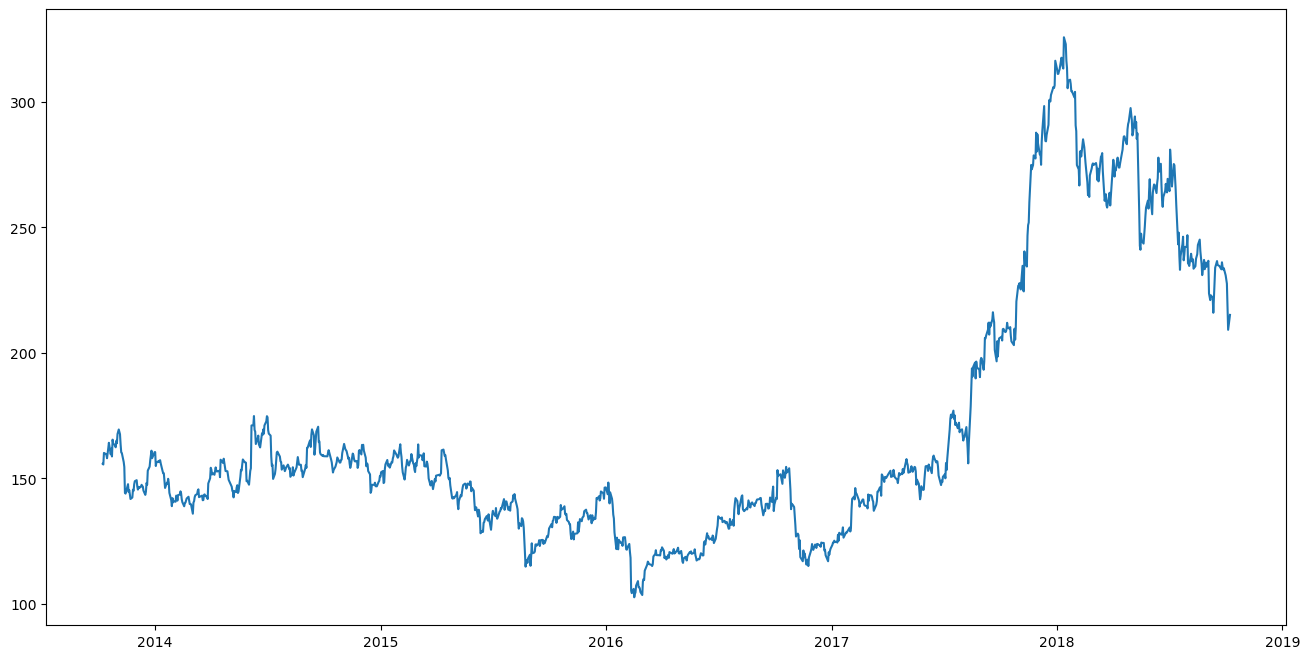

In [43]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [44]:
data = df.sort_index(ascending=True, axis=0)
new_dataset = data[['Date', 'Close']].reset_index(drop=True)


In [45]:
new_dataset.index = new_dataset['Date']
new_dataset.drop('Date', axis=1, inplace=True)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_dataset)

# Splitting the data into training and validation sets
train_data = scaled_data[:987, :]
valid_data = scaled_data[987:, :]

# Creating sequences for the training data
x_train_data, y_train_data = [], []

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i, 0])
    y_train_data.append(scaled_data[i, 0])

# Converting lists to numpy arrays
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

# Reshaping the data for LSTM (3D array: samples, timesteps, features)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

# Optionally: Display shapes to verify
print("x_train_data shape:", x_train_data.shape)
print("y_train_data shape:", y_train_data.shape)


x_train_data shape: (927, 60, 1)
y_train_data shape: (927,)


In [46]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming new_dataset is already created and processed as per previous code

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

# Prepare input data for prediction
inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scaler.transform(inputs_data)

# Compile the model
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
lstm_model.fit(x_train_data, y_train_data, epochs=10, batch_size=1, verbose=2)


Epoch 1/10


C:\Users\Akshat Agrawal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Akshat Agrawal\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


927/927 - 15s - 17ms/step - loss: 0.0010
Epoch 2/10
927/927 - 12s - 13ms/step - loss: 4.5597e-04
Epoch 3/10
927/927 - 12s - 13ms/step - loss: 3.3698e-04
Epoch 4/10
927/927 - 12s - 13ms/step - loss: 3.1097e-04
Epoch 5/10
927/927 - 13s - 14ms/step - loss: 2.7322e-04
Epoch 6/10
927/927 - 13s - 14ms/step - loss: 2.4671e-04
Epoch 7/10
927/927 - 12s - 13ms/step - loss: 2.6410e-04
Epoch 8/10
927/927 - 12s - 13ms/step - loss: 2.4074e-04
Epoch 9/10
927/927 - 12s - 13ms/step - loss: 2.4526e-04
Epoch 10/10
927/927 - 12s - 13ms/step - loss: 2.2105e-04


In [55]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)



In [56]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [57]:
lstm_model.save("saved_model.h5")

C:\Users\Akshat Agrawal\AppData\Local\Temp\ipykernel_24936\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


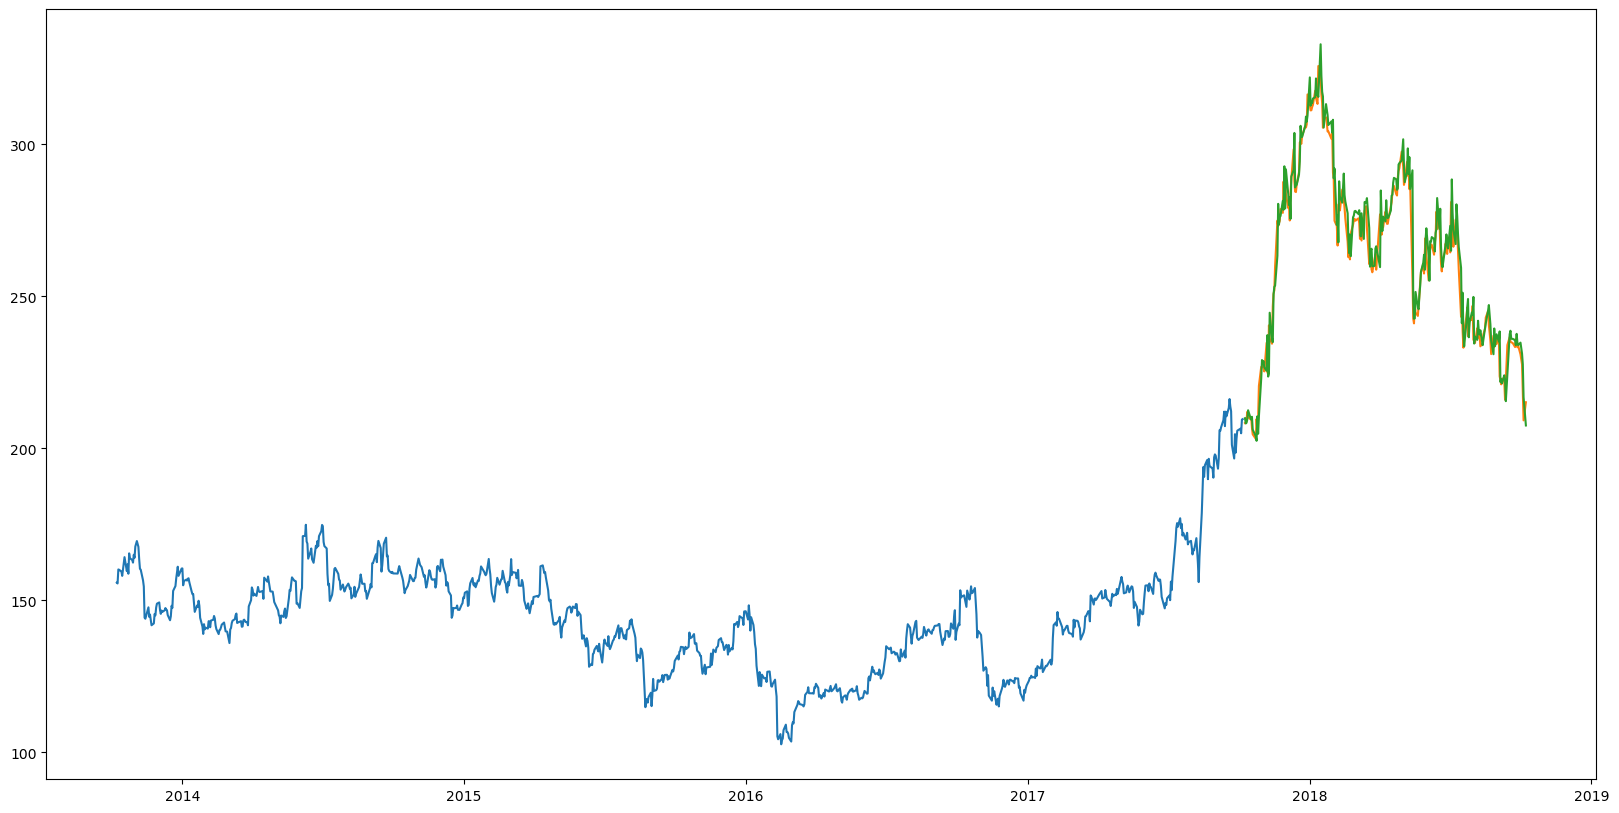

In [58]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])